# Preprocesamiento de datos
Este notebook se encarga de:
1. Cargar los datos limpios (no normalizados)
2. Dividir el conjunto de datos en:
   - Conjunto de entrenamiento (80%)
   - Conjunto de prueba (20%)
3. Normalizar los datos usando estadísticas SOLO del conjunto de entrenamiento
4. Guardar los conjuntos normalizados y los parámetros de normalización

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys

# Configura el estilo de visualización
plt.style.use('ggplot')
%matplotlib inline

# Añadir el directorio raíz al path para poder importar módulos personalizados
sys.path.append('..')
from utils.config import FEATURE_NAMES
from utils.preprocessing_functions import train_test_split

In [2]:
# Crear las carpetas de output si no existen
for folder in ['../output/models', '../output/figures']:
    os.makedirs(folder, exist_ok=True)

## 1. Carga de datos limpios (no normalizados)

In [3]:
print("Cargando datos limpios (no normalizados)...")
df = pd.read_csv('../data/processed/cleaned_data.csv')
print(f"Dimensiones del dataset: {df.shape}")
print(f"Primeras 5 filas del dataset:")
df.head()

Cargando datos limpios (no normalizados)...
Dimensiones del dataset: (569, 31)
Primeras 5 filas del dataset:


,diagnosis,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Análisis rápido de los datos cargados

In [4]:
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diagnosis  569 non-null    int64  
 1   f01        569 non-null    float64
 2   f02        569 non-null    float64
 3   f03        569 non-null    float64
 4   f04        569 non-null    float64
 5   f05        569 non-null    float64
 6   f06        569 non-null    float64
 7   f07        569 non-null    float64
 8   f08        569 non-null    float64
 9   f09        569 non-null    float64
 10  f10        569 non-null    float64
 11  f11        569 non-null    float64
 12  f12        569 non-null    float64
 13  f13        569 non-null    float64
 14  f14        569 non-null    float64
 15  f15        569 non-null    float64
 16  f16        569 non-null    float64
 17  f17        569 non-null    float64
 18  f18        569 non-null    float64
 19  f19        569 non-null 

# 3. Dividir los datos en conjuntos de entrenamiento y test
Los datos de prueba (test) los utiizaremos en la fase de predicción para evaluar la precisión del entrenamiento.

Dividiendo los datos en conjuntos de entrenamiento y prueba...
Tamaño conjunto de entrenamiento: 456 muestras (80.1% del total)
Tamaño conjunto de prueba: 113 muestras (19.9% del total)

Distribución de clases en cada conjunto:
Entrenamiento: {0: 286, 1: 170}
Prueba: {0: 71, 1: 42}


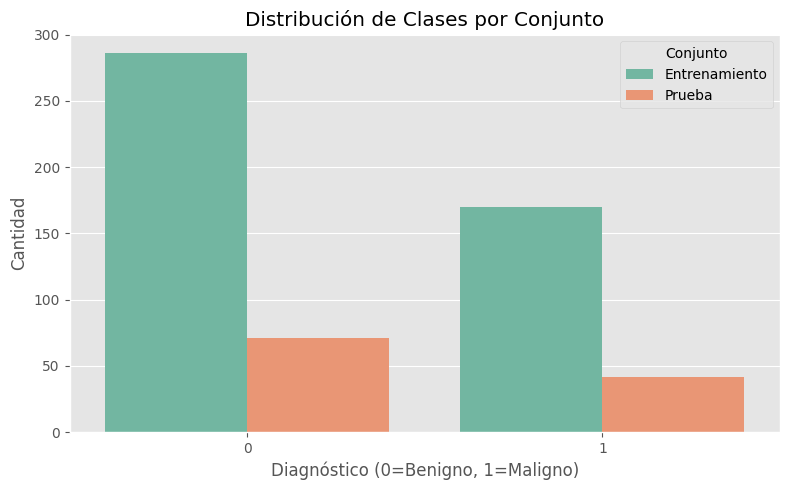

In [5]:
print("Dividiendo los datos en conjuntos de entrenamiento y prueba...")

# Separar características (X) y etiquetas (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# División: 80% para entrenamiento, 20% para prueba
# Ver la función train_test_split en utils.preprocessing_functions.py
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamaño conjunto de entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df):.1%} del total)")
print(f"Tamaño conjunto de prueba: {len(X_test)} muestras ({len(X_test)/len(df):.1%} del total)")

# Verificar la distribución de clases en cada conjunto
print("\nDistribución de clases en cada conjunto:")
print(f"Entrenamiento: {y_train.value_counts().to_dict()}")
print(f"Prueba: {y_test.value_counts().to_dict()}")

# Gráfico de distribución de clases por conjunto
# Crear un DataFrame largo para usar con seaborn
class_dist = []
for label, count in y_train.value_counts().items():
    class_dist.append({'Diagnóstico': label, 'Conjunto': 'Entrenamiento', 'Cantidad': count})
for label, count in y_test.value_counts().items():
    class_dist.append({'Diagnóstico': label, 'Conjunto': 'Prueba', 'Cantidad': count})
class_dist_df = pd.DataFrame(class_dist)

plt.figure(figsize=(8, 5))
sns.barplot(data=class_dist_df, x='Diagnóstico', y='Cantidad', hue='Conjunto', palette='Set2')
plt.title('Distribución de Clases por Conjunto')
plt.xlabel('Diagnóstico (0=Benigno, 1=Maligno)')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.savefig('../output/figures/class_distribution_by_set.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Normalización de datos (Z-score)

In [6]:
print("Normalizando datos con Z-score usando SOLO estadísticas del conjunto de entrenamiento...")

# Calcular estadísticas SOLO con los datos de entrenamiento
mean_train = X_train.mean()
std_train = X_train.std()

# Aplicar normalización Z-score manualmente
# Fórmula: X_normalizado = (X - media) / desviación_estándar
X_train_norm = (X_train - mean_train) / std_train
X_test_norm = (X_test - mean_train) / std_train

# Guardar parámetros de normalización para uso futuro
normalization_params = {
    'means': mean_train.to_dict(),
    'stds': std_train.to_dict()
}

with open('../output/normalization_params.json', 'w') as f:
    json.dump(normalization_params, f, indent=4)
print(f"Guardados parámetros de normalización en ../output/normalization_params.json")

Normalizando datos con Z-score usando SOLO estadísticas del conjunto de entrenamiento...
Guardados parámetros de normalización en ../output/normalization_params.json


## 5. Preparar los datos para el modelo
Para un perceptrón multicapa implementado manualmente, convertimos a arrays NumPy

In [7]:
# Conversión a arrays NumPy
X_train_array = X_train_norm.values
X_test_array = X_test_norm.values

y_train_array = y_train.values.reshape(-1, 1)  # Reshape para tener la dimensión correcta
y_test_array = y_test.values.reshape(-1, 1)

print(f"\nForma de los arrays de características:")
print(f"X_train: {X_train_array.shape}")
print(f"X_test: {X_test_array.shape}")

print(f"\nForma de los arrays de etiquetas:")
print(f"y_train: {y_train_array.shape}")
print(f"y_test: {y_test_array.shape}")


Forma de los arrays de características:
X_train: (456, 30)
X_test: (113, 30)

Forma de los arrays de etiquetas:
y_train: (456, 1)
y_test: (113, 1)


## 6. Guardar los conjuntos de datos procesados

In [8]:
# Guardar como CSV para uso posterior
print("\nGuardando conjuntos de datos procesados...")

# Guardar conjuntos de entrenamiento y prueba normalizados
datasets_norm = {
    'train': (X_train_norm, y_train),
    'test': (X_test_norm, y_test)
}

for name, (X_set, y_set) in datasets_norm.items():
    # Crear un DataFrame con características y etiqueta
    combined_df = pd.DataFrame()
    # Añadir diagnosis como primera columna
    combined_df['diagnosis'] = y_set.values
    # Añadir el resto de características
    for col in X_set.columns:
        combined_df[col] = X_set[col]
    
    # Guardar en CSV
    filepath = f'../data/processed/{name}_set_normalized.csv'
    combined_df.to_csv(filepath, index=False)
    print(f"Guardado conjunto normalizado {name} en {filepath}")

# Guardar los parámetros de división para reproducibilidad
split_params = {
    'train_size': len(X_train),
    'test_size': len(X_test),
    'train_pct': float(len(X_train)/len(df)),
    'test_pct': float(len(X_test)/len(df)),
    'stratify': True,
    'random_state': 42
}

with open('../output/split_params.json', 'w') as f:
    json.dump(split_params, f, indent=4)
print(f"Guardados parámetros de división en ../output/split_params.json")


Guardando conjuntos de datos procesados...
Guardado conjunto normalizado train en ../data/processed/train_set_normalized.csv
Guardado conjunto normalizado test en ../data/processed/test_set_normalized.csv
Guardados parámetros de división en ../output/split_params.json


# 7. Verificación de la distribución de características normalizadas


Verificando la distribución de características normalizadas entre conjuntos...


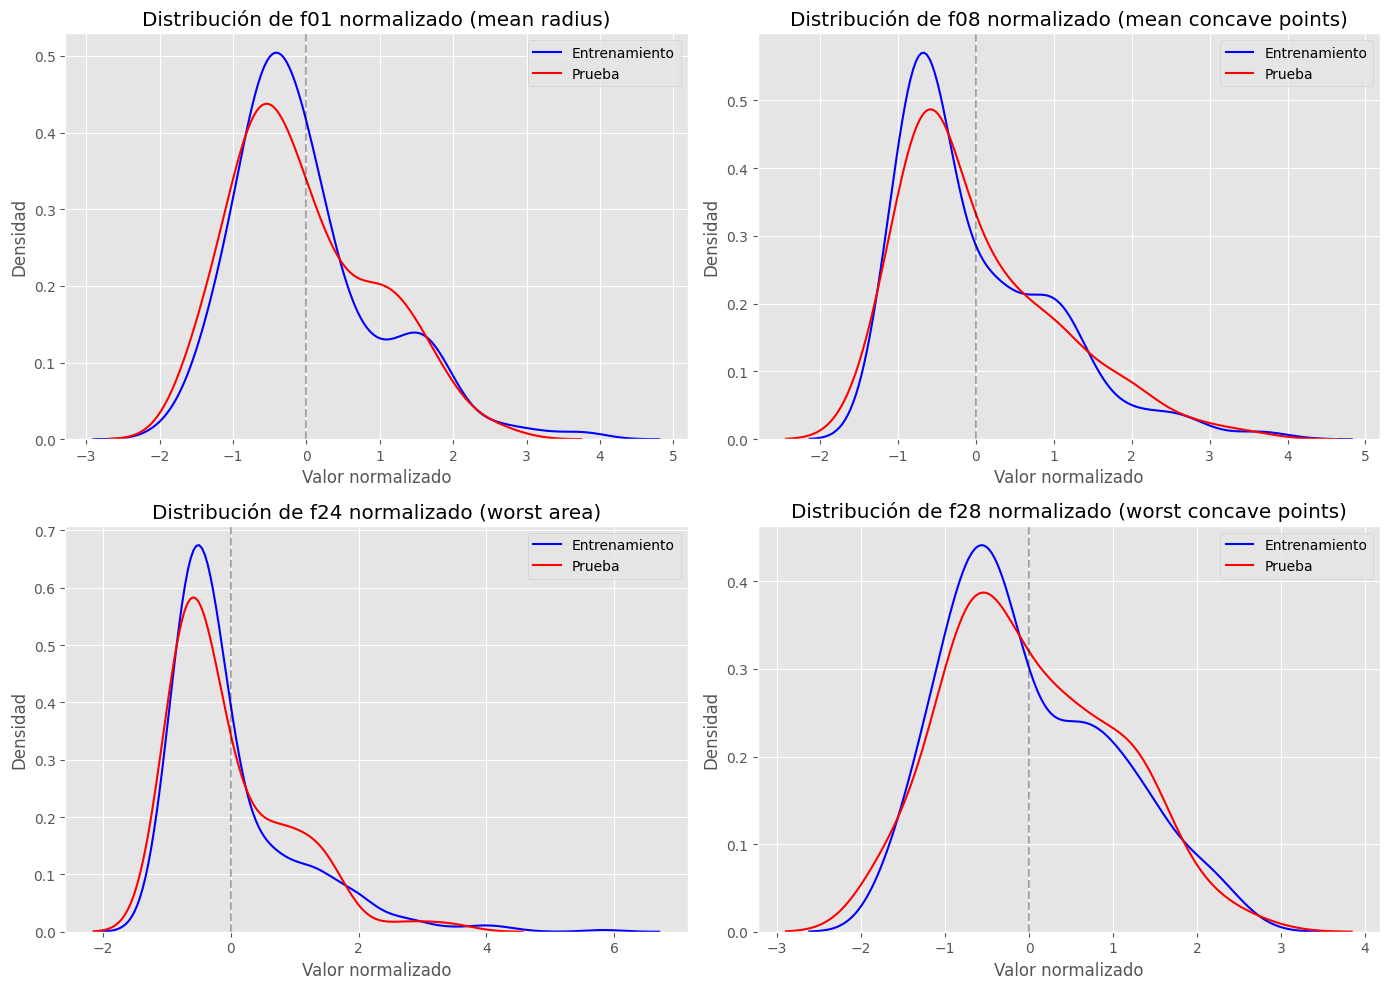

In [9]:
print("\nVerificando la distribución de características normalizadas entre conjuntos...")

# Seleccionar algunas características importantes basadas en análisis previo
important_features = ['f01', 'f08', 'f24', 'f28']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, feature in enumerate(important_features):
    sns.kdeplot(X_train_norm[feature], ax=axs[i], label='Entrenamiento', color='blue')
    sns.kdeplot(X_test_norm[feature], ax=axs[i], label='Prueba', color='red')
    
    axs[i].set_title(f'Distribución de {feature} normalizado ({FEATURE_NAMES[feature]})')
    axs[i].set_xlabel('Valor normalizado')
    axs[i].set_ylabel('Densidad')
    axs[i].axvline(x=0, color='black', linestyle='--', alpha=0.3)
    axs[i].legend()

plt.tight_layout()
plt.savefig('../output/figures/feature_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Resumen del preprocesamiento

In [10]:
print("\n=== Resumen del Preprocesamiento ===")
print(f"Dataset original: {len(df)} muestras, {df.shape[1]} características")
print("\nDivisión de datos:")
print(f"- Entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df):.1%})")
print(f"- Prueba: {len(X_test)} muestras ({len(X_test)/len(df):.1%})")

print("\nNormalización:")
print("- Método: Z-score manual (X - media) / desviación estándar")
print("- Estadísticas calculadas SOLO con datos de entrenamiento")
print("- Mismos parámetros aplicados al conjunto de prueba")
print("- Los parámetros de normalización se guardan para uso futuro en la fase de predicción")

print("\nArchivos generados:")
print("- CSVs con conjuntos normalizados: train_set_normalized.csv, test_set_normalized.csv")
print("  (con 'diagnosis' como primera columna)")
print("- Parámetros de normalización: normalization_params.json")
print("- Parámetros de división: split_params.json")

print("\nPróximos pasos:")
print("1. Desarrollar la arquitectura del perceptrón multicapa")
print("2. Implementar el algoritmo de entrenamiento")
print("3. Entrenar el modelo con los datos de entrenamiento")
print("4. Evaluar el rendimiento con los datos de prueba")


=== Resumen del Preprocesamiento ===
Dataset original: 569 muestras, 31 características

División de datos:
- Entrenamiento: 456 muestras (80.1%)
- Prueba: 113 muestras (19.9%)

Normalización:
- Método: Z-score manual (X - media) / desviación estándar
- Estadísticas calculadas SOLO con datos de entrenamiento
- Mismos parámetros aplicados al conjunto de prueba
- Los parámetros de normalización se guardan para uso futuro en la fase de predicción

Archivos generados:
- CSVs con conjuntos normalizados: train_set_normalized.csv, test_set_normalized.csv
  (con 'diagnosis' como primera columna)
- Parámetros de normalización: normalization_params.json
- Parámetros de división: split_params.json

Próximos pasos:
1. Desarrollar la arquitectura del perceptrón multicapa
2. Implementar el algoritmo de entrenamiento
3. Entrenar el modelo con los datos de entrenamiento
4. Evaluar el rendimiento con los datos de prueba
